In [14]:
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
import yfinance as yf

# Get stock data

In [15]:
ticker = 'AAPL'
start_date = '2010-01-01'
end_date = '2024-01-01'
stock_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed



# Visualizing closing prices

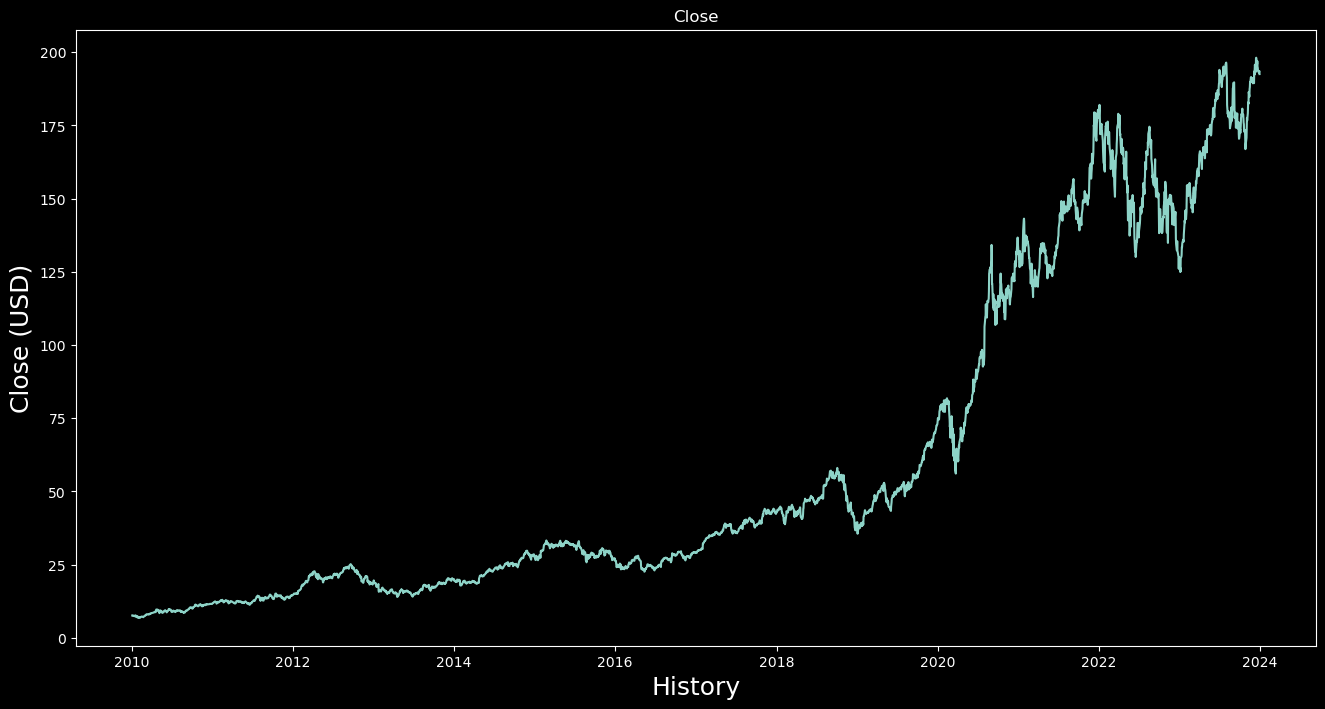

In [16]:
plt.style.use('dark_background')
plt.figure(figsize=(16, 8))
plt.title('Close')
plt.plot(stock_data['Close'])
plt.xlabel('History', fontsize=18)
plt.ylabel('Close (USD)', fontsize=18)
plt.show()

# Data preparation

In [17]:
data = stock_data.filter(['Close'])
dataset = data.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


# Training data length

In [18]:
training_data_len = int(len(dataset) * 0.8)
train_data = scaled_data[:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :]


In [19]:
print(train_data)

[[0.00410081]
 [0.00416991]
 [0.00353313]
 ...
 [0.59147943]
 [0.60183229]
 [0.59696957]]


In [20]:
print(training_data_len)

2817


In [21]:
print(len(dataset))

3522


# Creating a training dataset


In [23]:
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


# LSTM model creation and training


In [24]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.3))  # Dropout oranını artırdık
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))  # Dropout oranını artırdık
model.add(Dense(25))
model.add(Dense(1))

# Modeli derleme
model.compile(optimizer='adam', loss='mean_squared_error')

# Early Stopping callback'i ekleme
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modeli eğitme
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50


c:\Users\tltgk\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0022 - val_loss: 9.4861e-04
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1.0664e-04 - val_loss: 3.9067e-04
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 9.3304e-05 - val_loss: 4.6974e-04
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 6.8491e-05 - val_loss: 8.0887e-04
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 6.4559e-05 - val_loss: 6.0750e-04
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 6.3492e-05 - val_loss: 3.2729e-04
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 5.0619e-05 - val_loss: 6.1285e-04
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 6.3671e-05 - val_loss: 3.6309e-04
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 4.6765e-05 - val_loss: 8.6634e-04
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 5.1608e-05 - val_loss: 5.5900e-04
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.9359e-05 - val_loss: 8

# Testing the model


In [25]:
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


# Graphic drawing

C:\Users\tltgk\AppData\Local\Temp\ipykernel_35784\959086504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


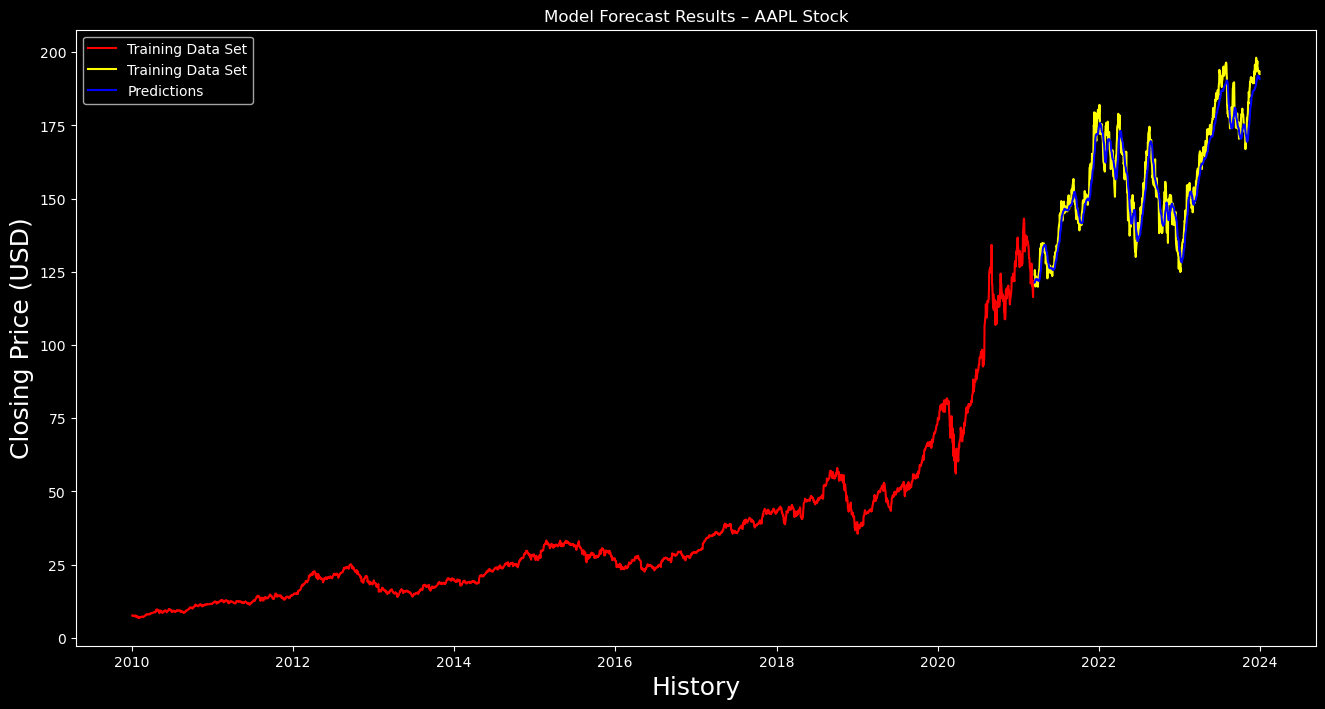

In [26]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model Forecast Results – AAPL Stock')
plt.xlabel('History', fontsize=18)
plt.ylabel('Closing Price (USD)', fontsize=18)

plt.plot(train['Close'], color='red', label='Training Data Set')
plt.plot(valid['Close'], color='yellow', label='Training Data Set')
plt.plot(valid['predictions'], color='blue', label='Predictions')

plt.legend(loc='upper left')  # Legend konumunu değiştirilebilir

plt.show()

# graphic drawing

In [27]:

train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid['predictions'] = predictions

# View last 20 days

In [28]:
print(valid.tail(20))

                 Close  predictions
Date                               
2023-12-01  191.240005   186.824814
2023-12-04  189.429993   186.945267
2023-12-05  193.419998   186.954178
2023-12-06  192.320007   187.142883
2023-12-07  194.270004   187.359116
2023-12-08  195.710007   187.702026
2023-12-11  193.179993   188.190109
2023-12-12  194.710007   188.577805
2023-12-13  197.960007   188.974106
2023-12-14  198.110001   189.549881
2023-12-15  197.570007   190.206696
2023-12-18  195.889999   190.837418
2023-12-19  196.940002   191.304520
2023-12-20  194.830002   191.702988
2023-12-21  194.679993   191.896667
2023-12-22  193.600006   191.939392
2023-12-26  193.050003   191.814407
2023-12-27  193.149994   191.556946
2023-12-28  193.580002   191.238083
2023-12-29  192.529999   190.927490


# Making price predictions for 1 month ahead

In [29]:
last_60_days = scaled_data[-60:]
X_test = np.array([last_60_days])
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price_1months = model.predict(X_test)
pred_price_1months = scaler.inverse_transform(pred_price_1months)
print(f'{ticker} Price after 1 month for: {pred_price_1months[0][0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
AAPL Price after 1 month for: 190.57626342773438
